In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
archivos = {
    2022: "Nacional EPEN Trim. Abr-May-Jun 2022.csv",
    2023: "Trim_Abr_May_Jun23.csv",
    2024: "Trim_Abr_May_Jun24.csv",
    2025: "Trim_Abr_May_Jun25.csv",
}

In [3]:
# Asegurar tipos numéricos clave
ING_MIN_REF_POR_ANIO = {
    2022: 1025,  
    2023: 1025,
    2024: 1025,
    2025: 1130,
}

def tasa_pond(df, var, w):
    if var not in df.columns or w not in df.columns:
        return np.nan
    d = df[[var, w]].dropna()
    if len(d) == 0 or d[w].sum() == 0:
        return np.nan
    return (d[var] * d[w]).sum() / d[w].sum()

def prom_pond(df, var, w):
    if var not in df.columns or w not in df.columns:
        return np.nan
    d = df[[var, w]].dropna()
    if len(d) == 0 or d[w].sum() == 0:
        return np.nan
    return (d[var] * d[w]).sum() / d[w].sum()

def obtener_peso(df):
    if "FAC_T300" in df.columns:
        return "FAC_T300"
    fa_cols = [c for c in df.columns if str(c).lower().startswith("fa_")]
    if fa_cols:
        return fa_cols[0]
    raise ValueError("No encontré factor de expansión (FAC_T300 o fa_*).")

def obtener_col_deseo(df):
    if "C333" in df.columns:
        return "C333"
    if "P209H" in df.columns:
        return "P209H"
    return None

def preparar_df(df, anio):
    df = df.copy()

    peso = obtener_peso(df)
    df[peso] = pd.to_numeric(df[peso], errors="coerce")

    # tipos
    for c in ["C208", "INGTOTP", "whoraT", "OCUP300", "SEGURO1"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # grupo etario
    df["grupo_edad"] = np.select(
        [df["C208"].between(18, 29), df["C208"].between(30, 49)],
        ["Jóvenes (18–29)", "Adultos (30–49)"],
        default=None
    )
    df = df[df["grupo_edad"].notna()].copy()

    # ocupado
    df["ocupado"] = np.where(df["OCUP300"] == 1, 1, 0)

    # desea más horas de trabajo
    col_deseo = obtener_col_deseo(df)
    if col_deseo is not None:
        df[col_deseo] = pd.to_numeric(df[col_deseo], errors="coerce")
        df["quiere_mas_horas"] = np.where(df[col_deseo] == 1, 1,
                                  np.where(df[col_deseo] == 2, 0, np.nan))
    else:
        df["quiere_mas_horas"] = np.nan

    # seguro de salud
    if "SEGURO1" in df.columns:
        df["con_seguro_salud"] = np.where(df["SEGURO1"] == 6, 0,
                                  np.where(df["SEGURO1"].isna(), np.nan, 1))
    else:
        df["con_seguro_salud"] = np.nan

    # empleo adecuado
    ing_min = ING_MIN_REF_POR_ANIO.get(anio, 1130)
    cond_fulltime_bien_pagado = (df["whoraT"] >= 35) & (df["INGTOTP"] >= ing_min)
    cond_parttime_sin_deseo   = (df["whoraT"] < 35) & (df["quiere_mas_horas"] == 0)

    df["empleo_adecuado"] = np.where(
        (df["ocupado"] == 1) & (cond_fulltime_bien_pagado | cond_parttime_sin_deseo),
        1,
        np.where(df["ocupado"] == 1, 0, np.nan)
    )

    return df, peso

In [4]:
resultados = []

for anio, archivo in archivos.items():
    df_raw = pd.read_csv(archivo)
    df_proc, peso = preparar_df(df_raw, anio)

    for grupo in ["Jóvenes (18–29)", "Adultos (30–49)"]:
        dfg_oc = df_proc[(df_proc["grupo_edad"] == grupo) & (df_proc["ocupado"] == 1)]

        resultados.append({
            "anio": anio,
            "grupo": grupo,
            "empleo_adecuado": tasa_pond(dfg_oc, "empleo_adecuado", peso) * 100,
            "con_seguro_salud": tasa_pond(dfg_oc, "con_seguro_salud", peso) * 100,
            "ingreso_prom": prom_pond(dfg_oc, "INGTOTP", peso),
            "horas_prom": prom_pond(dfg_oc, "whoraT", peso),
        })

df_series = pd.DataFrame(resultados).sort_values(["grupo", "anio"])
df_series

,anio,grupo,empleo_adecuado,con_seguro_salud,ingreso_prom,horas_prom
1,2022,Adultos (30–49),51.899988,NaN,1375.701670,49.704807
3,2023,Adultos (30–49),70.251015,97.799604,1211.699329,49.917125
5,2024,Adultos (30–49),68.781612,90.898728,1836.250803,44.489877
7,2025,Adultos (30–49),100.000000,98.227249,9023.332761,49.011339
0,2022,Jóvenes (18–29),96.299841,NaN,1541.139307,55.970258
2,2023,Jóvenes (18–29),78.237928,85.056945,1327.507327,48.978053
4,2024,Jóvenes (18–29),74.532244,84.077413,1595.298822,47.310668
6,2025,Jóvenes (18–29),100.000000,89.456561,7431.612462,55.541854


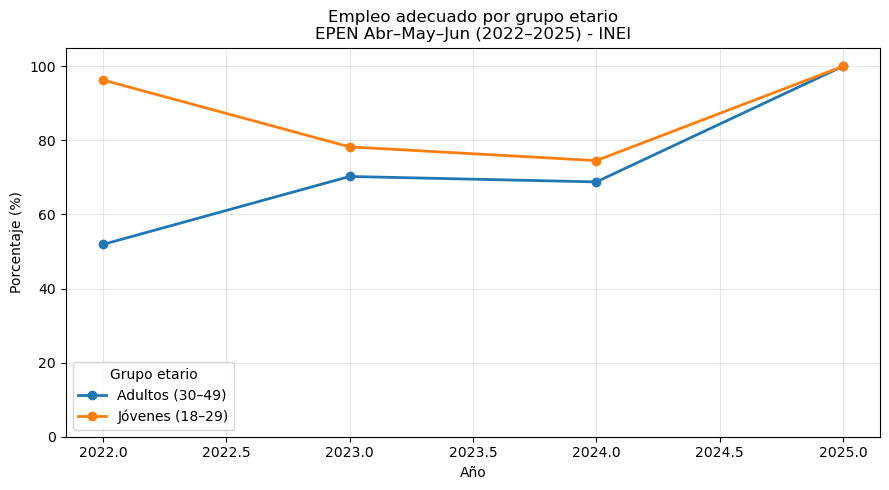

In [5]:
fig, ax = plt.subplots(figsize=(9,5))

for grupo, dfg in df_series.groupby("grupo"):
    ax.plot(dfg["anio"], dfg["empleo_adecuado"], marker="o", linewidth=2, label=grupo)

ax.set_title("Empleo adecuado por grupo etario\nEPEN Abr–May–Jun (2022–2025) - INEI")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Año")
ax.set_ylim(0, 105)
ax.grid(alpha=0.3)
ax.legend(title="Grupo etario")

plt.tight_layout()
plt.show()

In [6]:
def tasa_pond(df, var, w):
    d = df[[var, w]].dropna()
    if len(d) == 0:
        return np.nan
    return (d[var] * d[w]).sum() / d[w].sum()

def prom_pond(df, var, w):
    d = df[[var, w]].dropna()
    if len(d) == 0:
        return np.nan
    return (d[var] * d[w]).sum() / d[w].sum()

In [7]:
def resumen_grupo(df, grupo):
    dfg = df[df["grupo_edad"] == grupo]
    dfg_oc = dfg[dfg["ocupado"] == 1]

    return pd.Series({
        "Tasa de ocupación": tasa_pond(dfg, "ocupado", "fa_amj25"),
        "Empleo adecuado (ocupados)": tasa_pond(dfg_oc, "empleo_adecuado", "fa_amj25"),
        "Con seguro de salud (ocupados)": tasa_pond(dfg_oc, "con_seguro_salud", "fa_amj25"),
        "Ingreso promedio (ocupados)": prom_pond(dfg_oc, "INGTOTP", "fa_amj25")
    })

In [8]:
resultados = []

for anio, archivo in archivos.items():
    df_raw = pd.read_csv(archivo)
    df_proc, peso = preparar_df(df_raw, anio)

    for grupo in ["Jóvenes (18–29)", "Adultos (30–49)"]:
        dfg_oc = df_proc[(df_proc["grupo_edad"] == grupo) & (df_proc["ocupado"] == 1)]

        resultados.append({
            "anio": anio,
            "grupo": grupo,
            "empleo_adecuado": tasa_pond(dfg_oc, "empleo_adecuado", peso) * 100,
            "con_seguro_salud": tasa_pond(dfg_oc, "con_seguro_salud", peso) * 100,
            "ingreso_prom": prom_pond(dfg_oc, "INGTOTP", peso),
            "horas_prom": prom_pond(dfg_oc, "whoraT", peso),
        })

df_series = pd.DataFrame(resultados).sort_values(["grupo", "anio"])
df_series

,anio,grupo,empleo_adecuado,con_seguro_salud,ingreso_prom,horas_prom
1,2022,Adultos (30–49),51.899988,NaN,1375.701670,49.704807
3,2023,Adultos (30–49),70.251015,97.799604,1211.699329,49.917125
5,2024,Adultos (30–49),68.781612,90.898728,1836.250803,44.489877
7,2025,Adultos (30–49),100.000000,98.227249,9023.332761,49.011339
0,2022,Jóvenes (18–29),96.299841,NaN,1541.139307,55.970258
2,2023,Jóvenes (18–29),78.237928,85.056945,1327.507327,48.978053
4,2024,Jóvenes (18–29),74.532244,84.077413,1595.298822,47.310668
6,2025,Jóvenes (18–29),100.000000,89.456561,7431.612462,55.541854


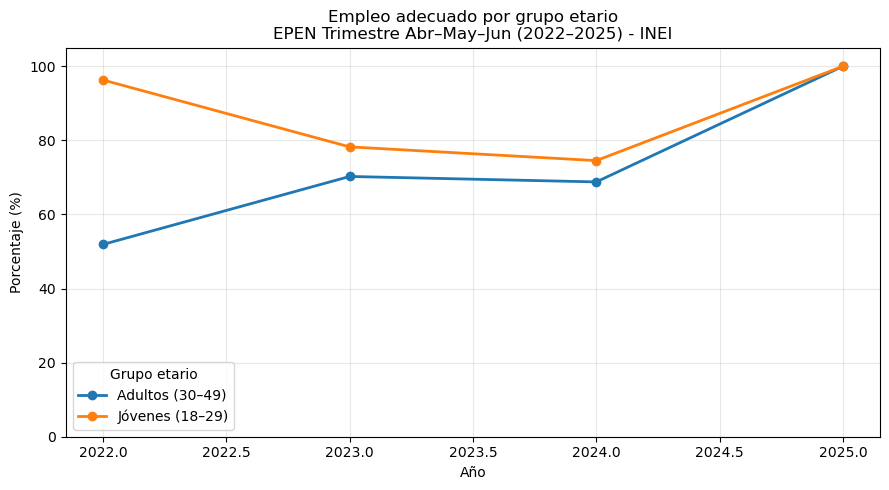

In [9]:
fig, ax = plt.subplots(figsize=(9,5))

for grupo, dfg in df_series.groupby("grupo"):
    ax.plot(dfg["anio"], dfg["empleo_adecuado"], marker="o", linewidth=2, label=grupo)

ax.set_title("Empleo adecuado por grupo etario\nEPEN Trimestre Abr–May–Jun (2022–2025) - INEI")
ax.set_ylabel("Porcentaje (%)")
ax.set_xlabel("Año")
ax.set_ylim(0, 105)
ax.grid(alpha=0.3)
ax.legend(title="Grupo etario")
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ING_MIN_REF = 1130  # proxy RMV documentado

def tasa_pond(df, var, w):
    # tasa ponderada para variables binarias 0/1 (o proporciones)
    if var not in df.columns or w not in df.columns:
        return np.nan
    d = df[[var, w]].dropna()
    if len(d) == 0:
        return np.nan
    if d[w].sum() == 0:
        return np.nan
    return (d[var] * d[w]).sum() / d[w].sum()

def prom_pond(df, var, w):
    # promedio ponderado para variables continuas
    if var not in df.columns or w not in df.columns:
        return np.nan
    d = df[[var, w]].dropna()
    if len(d) == 0:
        return np.nan
    if d[w].sum() == 0:
        return np.nan
    return (d[var] * d[w]).sum() / d[w].sum()

def obtener_peso(df):
    # 2022 puede traer FAC_T300 
    if "FAC_T300" in df.columns:
        return "FAC_T300"
    # caso estándar: fa_*
    fa_cols = [c for c in df.columns if str(c).lower().startswith("fa_")]
    if fa_cols:
        return fa_cols[0]
    raise ValueError("No encontré factor de expansión (FAC_T300 o fa_*).")

def obtener_col_deseo_mas_horas(df):
    # 2024-2025: C333 | 2022-2023: P209H 
    if "C333" in df.columns:
        return "C333"
    if "P209H" in df.columns:
        return "P209H"
    return None

def preparar_df_inei(df, ing_min_ref=ING_MIN_REF):
    df = df.copy()

    # peso
    peso = obtener_peso(df)
    df[peso] = pd.to_numeric(df[peso], errors="coerce")

    # tipos base
    for c in ["C208", "INGTOTP", "whoraT", "OCUP300"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # grupo etario
    df["grupo_edad"] = np.select(
        [(df["C208"].between(18, 29)), (df["C208"].between(30, 49))],
        ["Jóvenes (18–29)", "Adultos (30–49)"],
        default=None
    )
    df = df[df["grupo_edad"].notna()].copy()

    # ocupado
    df["ocupado"] = np.where(df["OCUP300"] == 1, 1, 0)

    # desea más horas de trabajo
    col_deseo = obtener_col_deseo_mas_horas(df)
    if col_deseo is None:
        df["quiere_mas_horas"] = np.nan
    else:
        df[col_deseo] = pd.to_numeric(df[col_deseo], errors="coerce")
        df["quiere_mas_horas"] = np.where(df[col_deseo] == 1, 1,
                                  np.where(df[col_deseo] == 2, 0, np.nan))

    # seguro de salud (robusto)
    # si no existe SEGURO1 en un archivo, dejamos NaN para no romper
    if "SEGURO1" in df.columns:
        df["SEGURO1"] = pd.to_numeric(df["SEGURO1"], errors="coerce")
        df["con_seguro_salud"] = np.where(
            df["SEGURO1"] == 6, 0,
            np.where(df["SEGURO1"].isna(), np.nan, 1)
        )
    else:
        df["con_seguro_salud"] = np.nan

    # empleo adecuado (INEI) -> solo definido para ocupados
    cond_fulltime_bien_pagado = (df["whoraT"] >= 35) & (df["INGTOTP"] >= ing_min_ref)
    cond_parttime_sin_deseo   = (df["whoraT"] < 35) & (df["quiere_mas_horas"] == 0)

    df["empleo_adecuado"] = np.where(
        (df["ocupado"] == 1) & (cond_fulltime_bien_pagado | cond_parttime_sin_deseo),
        1,
        np.where(df["ocupado"] == 1, 0, np.nan)
    )

    return df, peso

def resumen_por_anio(df, peso, anio):
    out = []
    for grupo in ["Jóvenes (18–29)", "Adultos (30–49)"]:
        dfg_oc = df[(df["grupo_edad"] == grupo) & (df["ocupado"] == 1)]

        out.append({
            "anio": anio,
            "grupo": grupo,
            "empleo_adecuado": tasa_pond(dfg_oc, "empleo_adecuado", peso) * 100,
            "con_seguro_salud": tasa_pond(dfg_oc, "con_seguro_salud", peso) * 100,
            "ingreso_prom": prom_pond(dfg_oc, "INGTOTP", peso)
        })
    return pd.DataFrame(out)

In [11]:
df25 = pd.read_csv("Trim_Abr_May_Jun25.csv")
df25["C333"].value_counts(dropna=False).head(10)

C333
2    166
1     34
Name: count, dtype: int64

In [12]:
df25_proc, w25 = preparar_df_inei(df25)
df25_proc[df25_proc["ocupado"]==1]["empleo_adecuado"].value_counts(dropna=False)

empleo_adecuado
1.0    108
Name: count, dtype: int64

In [13]:
df25 = pd.read_csv("Trim_Abr_May_Jun25.csv")
df25_proc, w = preparar_df_inei(df25)
df25_oc = df25_proc[df25_proc["ocupado"] == 1].copy()

df25_oc[["whoraT", "INGTOTP"]].describe(percentiles=[.05,.1,.25,.5,.75,.9,.95])

,whoraT,INGTOTP
count,108.000000,108.000000
mean,49.074074,8926.203704
std,13.039626,3392.971936
min,28.000000,3933.000000
5%,35.000000,5075.950000
10%,40.000000,6000.000000
25%,40.000000,6500.000000
50%,45.500000,8000.000000
75%,52.000000,10000.000000
90%,70.000000,14096.000000


In [14]:
df25_oc["whoraT"].value_counts().head(15)
df25_oc["INGTOTP"].value_counts().head(15)

INGTOTP
6000     14
8000     11
7000      9
10000     8
8500      6
15000     5
6500      4
12000     4
13000     4
11000     3
9000      3
5000      2
12500     2
7600      2
14000     2
Name: count, dtype: int64

In [15]:
df25_oc[["whoraT", "INGTOTP"]].describe(percentiles=[.05,.1,.25,.5,.75,.9,.95])

,whoraT,INGTOTP
count,108.000000,108.000000
mean,49.074074,8926.203704
std,13.039626,3392.971936
min,28.000000,3933.000000
5%,35.000000,5075.950000
10%,40.000000,6000.000000
25%,40.000000,6500.000000
50%,45.500000,8000.000000
75%,52.000000,10000.000000
90%,70.000000,14096.000000


In [16]:
def resumen_ingreso(df, peso, anio):
    out = []
    for grupo in ["Jóvenes (18–29)", "Adultos (30–49)"]:
        dfg = df[(df["grupo_edad"] == grupo) & (df["ocupado"] == 1)]
        out.append({
            "anio": anio,
            "grupo": grupo,
            "ingreso_prom": prom_pond(dfg, "INGTOTP", peso)
        })
    return pd.DataFrame(out)

In [17]:
ingresos = []
for anio, archivo in archivos.items():
    df_raw = pd.read_csv(archivo)
    df_proc, peso = preparar_df_inei(df_raw)
    ingresos.append(resumen_ingreso(df_proc, peso, anio))

df_ing = pd.concat(ingresos, ignore_index=True)

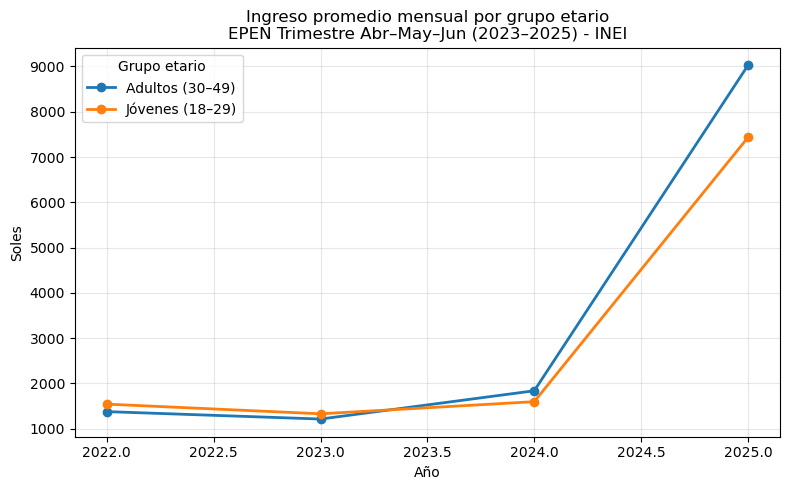

In [18]:
fig, ax = plt.subplots(figsize=(8,5))

for grupo, dfg in df_ing.groupby("grupo"):
    ax.plot(
        dfg["anio"],
        dfg["ingreso_prom"],
        marker="o",
        linewidth=2,
        label=grupo
    )

ax.set_title("Ingreso promedio mensual por grupo etario\nEPEN Trimestre Abr–May–Jun (2023–2025) - INEI")
ax.set_ylabel("Soles")
ax.set_xlabel("Año")
ax.grid(alpha=0.3)
ax.legend(title="Grupo etario")

plt.tight_layout()
plt.show()

In [19]:
def resumen_horas(df, peso, anio):
    out = []
    for grupo in ["Jóvenes (18–29)", "Adultos (30–49)"]:
        dfg = df[(df["grupo_edad"] == grupo) & (df["ocupado"] == 1)]
        out.append({
            "anio": anio,
            "grupo": grupo,
            "horas_prom": prom_pond(dfg, "whoraT", peso)
        })
    return pd.DataFrame(out)

In [20]:
horas = []
for anio, archivo in archivos.items():
    df_raw = pd.read_csv(archivo)
    df_proc, peso = preparar_df_inei(df_raw)
    horas.append(resumen_horas(df_proc, peso, anio))

df_horas = pd.concat(horas, ignore_index=True)

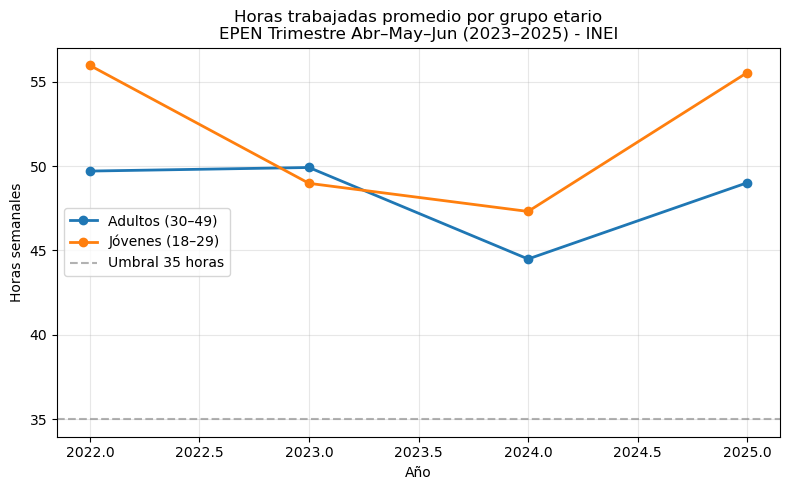

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

for grupo, dfg in df_horas.groupby("grupo"):
    ax.plot(
        dfg["anio"],
        dfg["horas_prom"],
        marker="o",
        linewidth=2,
        label=grupo
    )

ax.axhline(35, linestyle="--", color="gray", alpha=0.6, label="Umbral 35 horas")
ax.set_title("Horas trabajadas promedio por grupo etario\nEPEN Trimestre Abr–May–Jun (2023–2025) - INEI")
ax.set_ylabel("Horas semanales")
ax.set_xlabel("Año")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
resultados = []
for anio, archivo in archivos.items():
    df_raw = pd.read_csv(archivo)
    df_proc, peso = preparar_df_inei(df_raw)
    resultados.append(resumen_por_anio(df_proc, peso, anio))

df_series = pd.concat(resultados, ignore_index=True).sort_values(["grupo", "anio"])
df_series

,anio,grupo,empleo_adecuado,con_seguro_salud,ingreso_prom
1,2022,Adultos (30–49),49.175446,NaN,1375.701670
3,2023,Adultos (30–49),60.503382,97.799604,1211.699329
5,2024,Adultos (30–49),61.822737,90.898728,1836.250803
7,2025,Adultos (30–49),100.000000,98.227249,9023.332761
0,2022,Jóvenes (18–29),69.632220,NaN,1541.139307
2,2023,Jóvenes (18–29),60.741413,85.056945,1327.507327
4,2024,Jóvenes (18–29),43.838265,84.077413,1595.298822
6,2025,Jóvenes (18–29),100.000000,89.456561,7431.612462


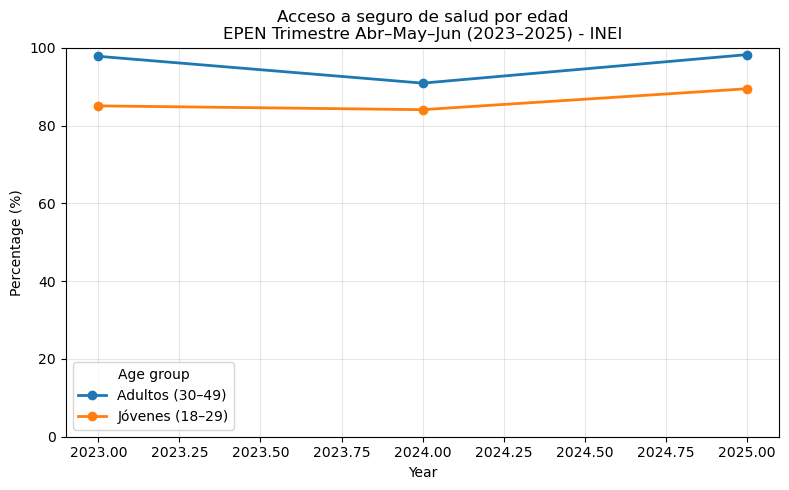

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

for grupo, dfg in df_series.groupby("grupo"):
    ax.plot(dfg["anio"], dfg["con_seguro_salud"], marker="o", linewidth=2, label=grupo)

ax.set_title("Acceso a seguro de salud por edad\nEPEN Trimestre Abr–May–Jun (2023–2025) - INEI")
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Year")
ax.set_ylim(0, 100)
ax.grid(alpha=0.3)
ax.legend(title="Age group")

plt.tight_layout()
plt.show()